In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun, L_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
general_method_interp = "linear"
#general_method_interp = "pchip"

In [3]:
#Set the object ID.
wid = "W0204-0506"

In [4]:
#Load the object properties.
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pws = dict()
cone_types = ["Top", "Bottom", "Full"]
for cone_type in cone_types:
    pws[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method=general_method_interp, get_scatt_frac=True)

pws_linear = dict()
for cone_type in cone_types:
    pws_linear[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='linear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

chi2_map[wid] = dict()
for cone_type in cone_types:
    if cone_type=="Full":
        fname = "../SKIRTOR_fit/maps/chi2_map_{}.fits".format(wid)
    else:
        fname = "maps_{}Cone/chi2_map_{}.fits".format(cone_type, wid)
    h = fits.open(fname)
    tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
    tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
    cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
    cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
    iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
    iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
    chi2_map[wid][cone_type] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
    chi2_map[wid][cone_type][:,:,:] = h[0].data
    chi2_map[wid][cone_type].mask = h[1].data.astype(bool)


In [7]:
#Set the wavelength grid we will work with. 
lam_grid = np.arange(1200., 3000., 20.)*u.AA

Top 32.5 deg 21.0 deg 56.0 deg 7.689583731337499e-10
0.5112693516481035
Bottom 50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08
0.26577194251026875
Full 28.0 deg 15.0 deg 48.5 deg 3.83571358380841e-08
0.35278508482356613


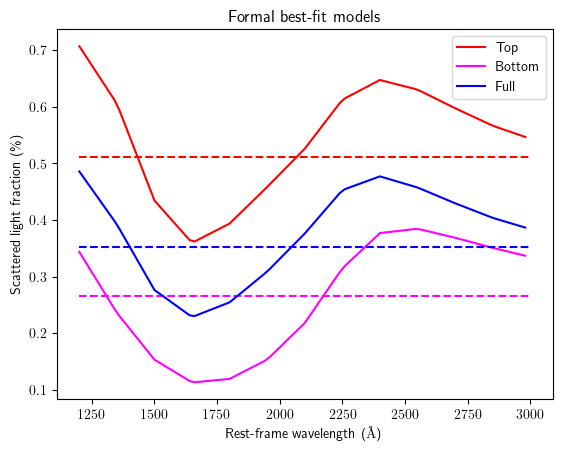

In [8]:
#Find the best solution for W0204-0506 and display the scattering fraction curves for each scenario. 
colors = ['red', 'magenta', 'blue']
for n, cone_type in enumerate(cone_types):

    #Get the coefficients of the formal best fit model. 
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    print(cone_type, tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid][cone_type].min())

    #Get the scattering fraction as a function of wavelength as well as the mean value.
    scatt_frac = 100.*pws[cone_type].scatt_frac((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid))
    plt.plot(lam_grid, scatt_frac, label=cone_type, ls='solid', color=colors[n])

    mean_scatt_frac = 100. * pws[cone_type].mean_scatt_frac(tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1]).flatten()[0]
    plt.plot([1200.,3000.], [mean_scatt_frac]*2, ls='dashed', color=colors[n])
    print(mean_scatt_frac)

plt.ylabel('Scattered light fraction (\%)')
plt.xlabel(r'Rest-frame wavelength ($\rm \AA$)')
plt.title('Formal best-fit models')
plt.legend()

In [9]:
#Now, get for the top and bottom cones the mean scattered fraction for all combinations of angles.
mean_scatt_frac_top = pws['Top'].mean_scatt_frac(tang_grid, cang_grid, iang_grid)
mean_scatt_frac_bot = pws['Bottom'].mean_scatt_frac(tang_grid, cang_grid, iang_grid)

In [10]:
#Here we will set some matrices that will be useful, that unify the top and bottom cones as cones with positive and negative inclination. 

#Set the extended grid in inclinations angles to have positive and negative ones. 
diang = np.mean(iang_grid[1:]-iang_grid[:-1]).value
iang_grid_extended = np.arange(-90., 90.1, diang)*u.deg
nie = len(iang_grid_extended) 
nt, nc, ni = chi2_map[wid][cone_types[0]].shape

#Set the chi2 map. Mask the regions that do not have any data.
chi2_use = np.ma.zeros((nt, nc, nie))
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)

chi2_use[:,:,:ni] = np.copy(chi2_map[wid][cone_types[1]][:,:,::-1])
chi2_use[:,:,nie-ni:] = np.copy(chi2_map[wid][cone_types[0]])
chi2_use.mask[:,:,ni:nie-ni] = True

#Set the mean scattering fraction map. 
mean_scatt_frac = np.zeros((nt, nc, nie))
mean_scatt_frac[:,:,:ni] = np.copy(mean_scatt_frac_bot[:,:,::-1])
mean_scatt_frac[:,:,nie-ni:] = np.copy(mean_scatt_frac_top)

#Set the 2D angle vectors. II is torus opening angle, JJ is cone opening angle (to the end of the dust, that is why we add 10 to the grid value which only representes the opening of the dustless region), and KK is the inclination. 
II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value+10, iang_grid_extended.value, indexing='ij')

#Mask the regions of the parameter space that are no allowed. JJ>II means when the cone is larger than the torus, and KK<II means when the inclination is smaller than the inclination angle and hence we would have a direct line of sight to the accretion disk. 
chi2_use.mask[(JJ>II) | (np.abs(KK)<II)] = True

#Finally, mask the regions where the chi2 is greater than 5. 
vmin = np.min(chi2_use)
vmax = 5.0 #3.0
chi2_use.mask[chi2_use>vmax] = True

In [11]:
#Function to get error intervals from a histogram. 
def get_errors(binned_values, bin_edges, p=[2.3, 15.85, 50., 84.15, 97.7]):

    vals_cumulative = np.cumsum(binned_values)/np.sum(binned_values)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    ps = np.interp(p, vals_cumulative*100, bin_centers)
    return ps


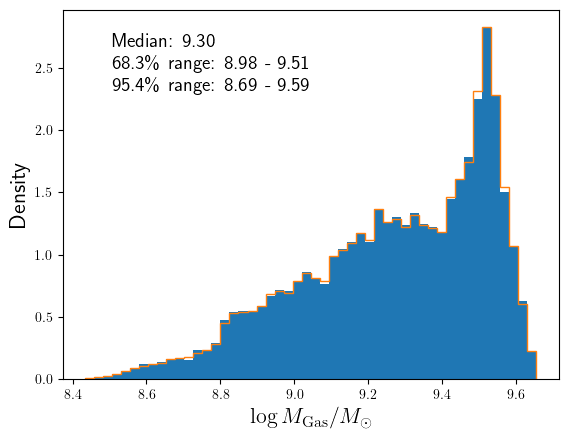

In [12]:
#We'll get the gas mass for every allowed combination of parameters, and then weigh each pf them by the likelihood and add the weighted numbers to get the distribution. 

#We scale the tau_V by the mean scattered fraction compared to the measured value. The fraction of scattered light should scale linearly with the optical depth at the level we care about. Check with Marko.  
tau_V = 0.1 * 0.013/mean_scatt_frac

#Paremeters of the model
delta_psi_c = 10*u.deg #Dusty shell of the cone.
#psi_c = np.array([10, 38, 40])*u.deg
X = 1.5e-23*u.cm**2 #dust to gas ratio.
L = 10*u.kpc #Length of the cone.
Rv = 3.1

#Calculate the gas mass. 
Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(JJ*u.deg-delta_psi_c/2.)*(np.sin(JJ*u.deg))**2

#Set the figure. 
fig, ax = plt.subplots(1)

#Plot the distribution of gas mass values, weighted by the likelihood. 
binned_lMg_vals, binned_lMg_bin_edges, _ = ax.hist(np.log10(Mg[~chi2_use.mask]/(M_sun)).to(u.dimensionless_unscaled), density=True, bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

#Also plot it without the likelihood weights to see the difference. 
ax.hist(np.log10(Mg[~chi2_use.mask]/(M_sun)).to(u.dimensionless_unscaled), density=True, bins=binned_lMg_bin_edges, histtype='step')

#Get the formal values. 
lMg_ps = get_errors(binned_lMg_vals, binned_lMg_bin_edges)
ax.text(0.1, 0.9, "Median: {:.2f}".format(lMg_ps[2]), transform=ax.transAxes, fontsize=14)
ax.text(0.1, 0.84, "68.3\% range: {:.2f} - {:.2f}".format(lMg_ps[1], lMg_ps[3]), transform=ax.transAxes, fontsize=14)
ax.text(0.1, 0.78, "95.4\% range: {:.2f} - {:.2f}".format(lMg_ps[0], lMg_ps[4]), transform=ax.transAxes, fontsize=14)

ax.set_xlabel(r"$\log M_{\rm Gas}/M_{\odot}$", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
plt.show()

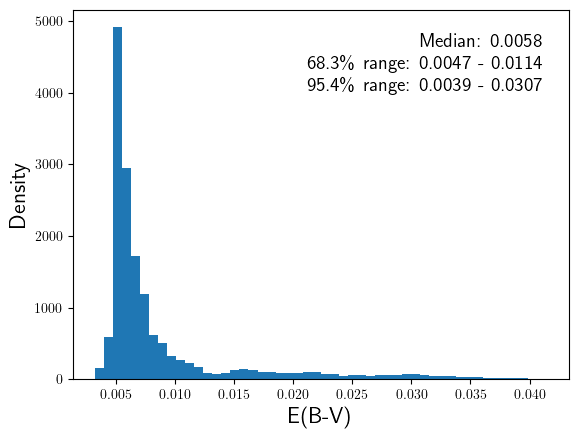

In [13]:
#Now the obscuration of a light ray going through the dusty section of the cone at mid-height
d = 0.5*L*(np.sin(JJ*u.deg)-np.sin(JJ*u.deg-delta_psi_c))
n_H = (2.5/np.log(10.)) * tau_V/(X*Rv) * np.cos(JJ*u.deg-delta_psi_c/2.)/L
ebv = X*n_H*d

fig, ax = plt.subplots(1)
binned_ebv_vals, binned_ebv_bin_edges, _ = ax.hist(ebv[~chi2_use.mask], bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

#Get the formal values. 
ebv_ps = get_errors(binned_ebv_vals, binned_ebv_bin_edges)
ax.text(0.95, 0.9, "Median: {:.4f}".format(ebv_ps[2]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.84, "68.3\% range: {:.4f} - {:.4f}".format(ebv_ps[1], ebv_ps[3]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.78, "95.4\% range: {:.4f} - {:.4f}".format(ebv_ps[0], ebv_ps[4]), transform=ax.transAxes, fontsize=14, ha='right')

ax.set_xlabel("E(B-V)", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
plt.show()

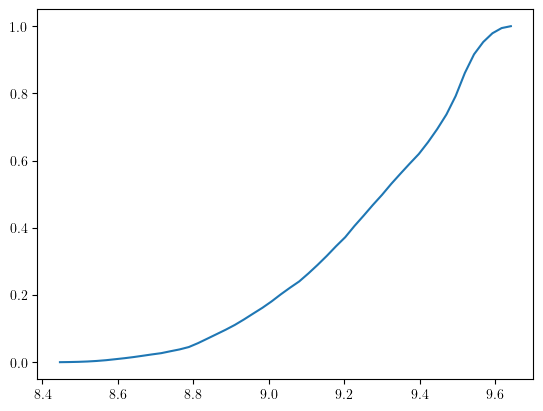

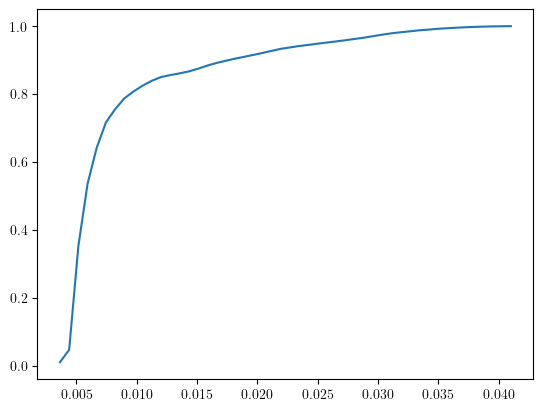

In [14]:
lMg_cumulative = np.cumsum(binned_lMg_vals)/np.sum(binned_lMg_vals)
lMg_bin_centers = 0.5*(binned_lMg_bin_edges[1:] + binned_lMg_bin_edges[:-1])
plt.plot(lMg_bin_centers, lMg_cumulative)
plt.show()

ebv_cumulative = np.cumsum(binned_ebv_vals)/np.sum(binned_ebv_vals)
ebv_bin_centers = 0.5*(binned_ebv_bin_edges[1:] + binned_ebv_bin_edges[:-1])
plt.plot(ebv_bin_centers, ebv_cumulative)
plt.show()

In [15]:
#Outflow FWHM
min_inclination = 45.*u.deg
FWHM_min = 616.*u.km/u.s / np.cos(45*u.deg)
FWHM_ref = 616.*u.km/u.s / np.cos(60*u.deg)
print(FWHM_min, FWHM_ref)

#Min inclination to match range of Finnerty
inc_finnerty = np.arccos(616.*u.km/u.s / (1500.*u.km/u.s))
print(inc_finnerty.to(u.deg))

871.1555544218265 km / s 1231.9999999999998 km / s
65.75327935998175 deg


In [16]:
#Estimate the outflow mass rate following Finnerty et al. (2020)

#Outflow velocity
FWHM_outflow = 616.*u.km/u.s/ np.cos(KK*u.deg)
sigma_outflow = FWHM_outflow/(2*(2*np.log(2.))**0.5)
v_out = 2*sigma_outflow

#Distance
R_out = 10*u.kpc

#Mass outflow rate
M_out_dot = 3.*Mg*v_out/R_out

#Energy outflow rate
E_out_dot = 3*Mg*v_out**3/(2.*R_out)

#Momentum flux
P_out = 3*Mg*v_out**2/R_out


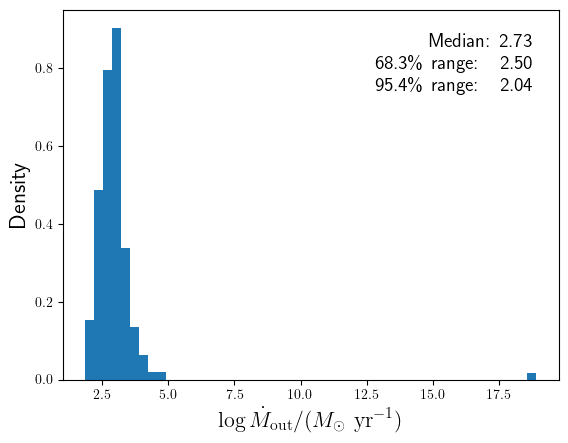

[108.86865835 316.98350778 536.35008737] 73.5617584590232


In [17]:
#Set the figure. 
fig, ax = plt.subplots(1)

#Plot the distribution of gas mass values, weighted by the likelihood. 
binned_lMod_vals, binned_lMod_bin_edges, _ = ax.hist(np.log10(M_out_dot[~chi2_use.mask]/(M_sun/u.yr)).to(u.dimensionless_unscaled), density=True, bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

#Get the formal values. 
lMod_ps = get_errors(binned_lMod_vals, binned_lMod_bin_edges, p=[4.6, 31.7, 50.])
ax.text(0.95, 0.9, "Median: {:.2f}".format(lMod_ps[2]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.84, "68.3\% range: \> {:.2f}".format(lMod_ps[1]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.78, "95.4\% range: \> {:.2f}".format(lMod_ps[0]), transform=ax.transAxes, fontsize=14, ha='right')

ax.set_xlabel(r"$\log \dot{M}_{\rm out}/(M_{\odot}~\rm yr^{-1})$", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
plt.show()

print(10**lMod_ps, (np.min(M_out_dot[~chi2_use.mask])/(M_sun/u.yr)).to(u.dimensionless_unscaled))


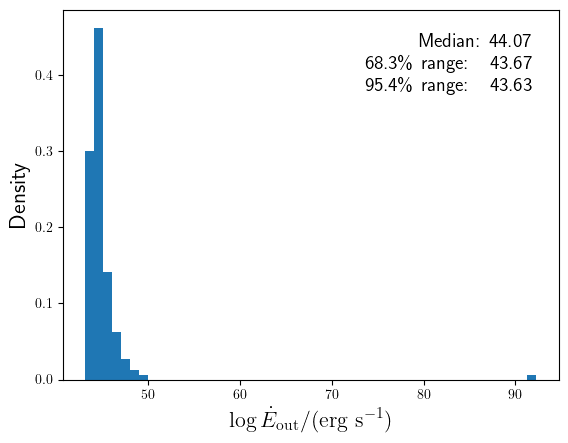

[4.22620126e+43 4.71726058e+43 1.17445174e+44]


In [18]:
#Set the figure. 
fig, ax = plt.subplots(1)

#Plot the distribution of gas mass values, weighted by the likelihood. 
binned_lEod_vals, binned_lEod_bin_edges, _ = ax.hist(np.log10(E_out_dot[~chi2_use.mask]/(u.erg/u.s)).to(u.dimensionless_unscaled), density=True, bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

#Get the formal values. 
lEod_ps = get_errors(binned_lEod_vals, binned_lEod_bin_edges, p=[4.6, 31.7, 50.])
ax.text(0.95, 0.9, "Median: {:.2f}".format(lEod_ps[2]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.84, "68.3\% range: \> {:.2f}".format(lEod_ps[1]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.78, "95.4\% range: \> {:.2f}".format(lEod_ps[0]), transform=ax.transAxes, fontsize=14, ha='right')

ax.set_xlabel(r"$\log \dot{E}_{\rm out}/(\rm erg~\rm s^{-1})$", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
plt.show()

print(10**lEod_ps)


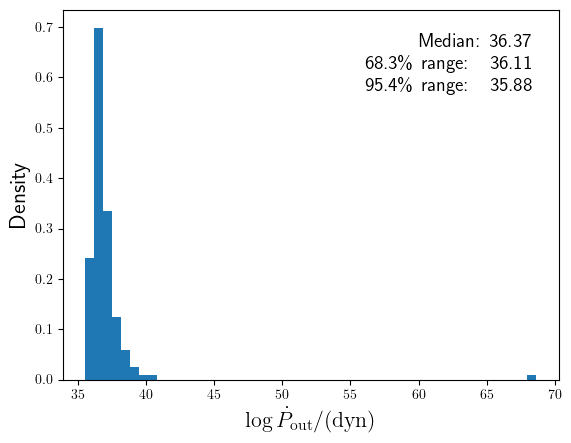

[7.61451931e+35 1.27994229e+36 2.33877016e+36]


In [19]:
#Set the figure. 
fig, ax = plt.subplots(1)

#Plot the distribution of gas mass values, weighted by the likelihood. 
binned_lPod_vals, binned_lPod_bin_edges, _ = ax.hist(np.log10(P_out[~chi2_use.mask]/(u.dyn)).to(u.dimensionless_unscaled), density=True, bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

#Get the formal values. 
lPod_ps = get_errors(binned_lPod_vals, binned_lPod_bin_edges, p=[4.6, 31.7, 50.])
ax.text(0.95, 0.9, "Median: {:.2f}".format(lPod_ps[2]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.84, "68.3\% range: \> {:.2f}".format(lPod_ps[1]), transform=ax.transAxes, fontsize=14, ha='right')
ax.text(0.95, 0.78, "95.4\% range: \> {:.2f}".format(lPod_ps[0]), transform=ax.transAxes, fontsize=14, ha='right')

ax.set_xlabel(r"$\log \dot{P}_{\rm out}/(\rm dyn)$", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
plt.show()

print(10**lPod_ps)

In [20]:
10**lEod_ps[0], (10**lEod_ps[0] * u.erg/u.s/(4.4e13*L_sun)).to(u.dimensionless_unscaled) * 100

(4.2262012576864943e+43, <Quantity 0.02509144>)

In [24]:
#Fiducial model. 
inclination = 60.*u.deg
psi_cone    = 23.5 * u.deg + 10.*u.deg
psi_torus   = 40.0 * u.deg

#pws['Top'].mean_scatt_frac(psi_torus, psi_cone, inclination).flatten()[0]
tau_V = 0.1 * 0.013/pws['Top'].mean_scatt_frac(psi_torus, psi_cone, inclination).flatten()[0]

#Other parameters 
delta_psi_c = 10*u.deg #Dusty shell of the cone.
X = 1.5e-23*u.cm**2 #dust to gas ratio.
L = 10*u.kpc #Length of the cone.
Rv = 3.1

# #Paremeters of the model
# delta_psi_c = 10*u.deg #Dusty shell of the cone.
# #psi_c = np.array([10, 38, 40])*u.deg
# X = 1.5e-23*u.cm**2 #dust to gas ratio.
# L = 10*u.kpc #Length of the cone.
# Rv = 3.1
# tau_V = 

Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(psi_cone-delta_psi_c/2.)*(np.sin(psi_cone))**2
#print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)

#Outflow velocity
FWHM_outflow = 616.*u.km/u.s/ np.cos(inclination)
sigma_outflow = FWHM_outflow/(2*(2*np.log(2.))**0.5)
v_out = 2*sigma_outflow

#Distance
R_out = 10*u.kpc

#Mass outflow rate
M_out_dot = 3.*Mg*v_out/R_out

#Energy outflow rate
E_out_dot = 3*Mg*v_out**3/(2.*R_out)

#Momentum flux
P_out = 3*Mg*v_out**2/R_out

print((M_out_dot/(M_sun/u.yr)).to(u.dimensionless_unscaled))
print(np.log10((E_out_dot/(u.erg/u.s)).to(u.dimensionless_unscaled)))
print((E_out_dot/(4.4e13*L_sun)).to(u.dimensionless_unscaled)*100.)
print(np.log10((P_out/(u.dyn))).to(u.dimensionless_unscaled))
print((10**45.4*u.erg/u.s/(4.4e13*L_sun)).to(u.dimensionless_unscaled)*100.)


430.79062532544896
44.17200415036401
0.08822253745115788
36.45335116655414
1.4913356318927353
